In [1]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from isyatirimhisse import StockData, Financials

In [1084]:
financials = Financials()
df = financials.get_data(
    symbols='TAVHL',
    start_year='2010',
    save_to_excel=True
)


Data saved to financials_20240830


In [2]:
bilanco=pd.read_excel("financials_20240830.xlsx")

In [3]:
q1=bilanco[bilanco["itemDescTr"]=="Satış Gelirleri"].iloc[:,3:].T[::4]
satışlar=bilanco[bilanco["itemDescTr"]=="Satış Gelirleri"].iloc[:,3:].T


In [4]:
current_liabilities=bilanco[bilanco['itemDescTr'].str.contains('yükümlülük', case=False, na=False)].iloc[:4,3:].sum(axis=0)
total_liabilities=bilanco[bilanco['itemDescTr'].str.contains('yükümlülük', case=False, na=False)].iloc[:,3:].sum(axis=0)

In [5]:
current_assets = bilanco.loc[bilanco['itemDescEng'] == 'CURRENT ASSETS'].values[0][3:]
total_assets = bilanco.loc[bilanco['itemDescEng'] == 'TOTAL ASSETS'].values[0][3:]
shareholders_equity = bilanco.loc[bilanco['itemDescEng'] == 'SHAREHOLDERS EQUITY'].values[0][3:]
net_profit_after_taxes = bilanco.loc[bilanco['itemDescEng'] == 'NET PROFIT AFTER TAXES'].values[0][3:]
domestic_sales = bilanco.loc[bilanco['itemDescEng'] == 'Domestic Sales'].values[0][3:]
export_sales = bilanco.loc[bilanco['itemDescEng'] == 'Export Sales'].values[0][3:]
netkar=bilanco.loc[bilanco['itemDescTr'] == 'Dönem Net Kar/Zararı'].values[0][3:]
özkaynaklar=bilanco.loc[bilanco['itemDescTr'] == 'Özkaynaklar'].values[0][3:]
satışlar=bilanco.loc[bilanco['itemDescTr'] == 'Satış Gelirleri'].values[0][3:]
brütkar=bilanco.loc[bilanco['itemDescTr'] == 'BRÜT KAR (ZARAR)'].values[0][3:]
faaliyetkarı=bilanco.loc[bilanco['itemDescTr'] == 'FAALİYET KARI (ZARARI)'].values[0][3:]
# Calculate the ratios
current_ratio = current_assets / current_liabilities
debt_to_equity_ratio = total_liabilities / shareholders_equity
return_on_equity = net_profit_after_taxes / shareholders_equity
net_profit_margin = net_profit_after_taxes / satışlar
roe=netkar/özkaynaklar
asset_turnover=satışlar/total_assets
brütkarmarjı=brütkar/satışlar
faaliyetkarmarj=faaliyetkarı/satışlar

def tolist(array):
    array=pd.DataFrame(array).reset_index()
    del array["index"]
    return array
current_ratio=tolist(current_ratio)
debt_to_equity_ratio=tolist(debt_to_equity_ratio)
return_on_equity=tolist(return_on_equity)
net_profit_margin=tolist(net_profit_margin)
roe=tolist(roe)
asset_turnover=tolist(asset_turnover)
brütkarmarjı=tolist(brütkarmarjı)
faaliyetkarmarj=tolist(faaliyetkarmarj)
satışlar=tolist(satışlar)
netkar=tolist(netkar)
current_assets=tolist(current_assets)
total_assets=tolist(total_assets)
net_profit_after_taxes=tolist(net_profit_after_taxes)
özkaynaklar=tolist(özkaynaklar)
brütkar=tolist(brütkar)
faaliyetkarı=tolist(faaliyetkarı)

In [6]:
hisse=yf.download(tickers="TAVHL.IS",start="2010-01-01",interval="1mo")
hisse = hisse.resample('Q').agg({'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'mean',
    'Volume': 'sum'
})
hisse["Return"]=((hisse["Close"].shift(-2)/hisse["Close"])-1)*100

[*********************100%***********************]  1 of 1 completed
C:\Users\Bora\AppData\Local\Temp\ipykernel_18284\167308702.py:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  hisse = hisse.resample('Q').agg({'Open': 'first',


In [7]:
rasyo=pd.concat([current_ratio,debt_to_equity_ratio,return_on_equity,net_profit_margin,roe,asset_turnover,brütkarmarjı,faaliyetkarmarj,satışlar,netkar,current_assets,total_assets,net_profit_after_taxes,özkaynaklar,brütkar,faaliyetkarı],axis=1)
rasyo.columns=["Cari Oran","Borçluluk Oranı","Return On Equity","Net Kar Marjı","ROE","Devir Hızı","Brüt Kar Marjı","Faaliyet Kar Marjı","s","n","c","t","favök","özkaynak","brütkar","faaliyetkarı"]
rasyo["Fiyat"]=hisse["Close"].values[:-1]
rasyo["Return"]=hisse["Return"].values[:-1]
rasyo=rasyo.set_index(pd.date_range(start="2010-03-31",freq="Q",periods=len(rasyo)))
rasyo=rasyo.iloc[2:,:]
rasyo["Return"]=rasyo["Return"].fillna(0)
rasyo

C:\Users\Bora\AppData\Local\Temp\ipykernel_18284\785113168.py:5: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  rasyo=rasyo.set_index(pd.date_range(start="2010-03-31",freq="Q",periods=len(rasyo)))


,Cari Oran,Borçluluk Oranı,Return On Equity,Net Kar Marjı,ROE,Devir Hızı,Brüt Kar Marjı,Faaliyet Kar Marjı,s,n,c,t,favök,özkaynak,brütkar,faaliyetkarı,Fiyat,Return
2010-09-30,1.187166,3.325149,0.07777,0.071396,0.066045,0.273261,0.322807,0.188458,1099765894.0,66682069.0,1331276755.0,4024606068.0,78519345.0,1009639635.0,355012154.0,207260126.0,6.950000,2.541967
2010-12-31,1.201104,3.025843,0.09274,0.068406,0.089401,0.359219,0.293102,0.159954,1501207066.0,98993553.0,1367891599.0,4179087055.0,102691163.0,1107303831.0,440006424.0,240124457.0,7.400000,9.549549
2011-03-31,1.135096,2.995258,-0.031135,-0.093195,-0.026796,0.088836,0.212573,0.073757,387326000.0,-31066472.0,1215548199.0,4360035822.0,-36097000.0,1159361913.0,82335000.0,28568000.0,7.126667,5.332088
2011-06-30,1.104006,3.105842,-0.011279,-0.015091,-0.008101,0.194418,0.263063,0.138244,922421000.0,-9998851.0,1387997432.0,4744524905.0,-13920000.0,1234204036.0,242655000.0,127519000.0,8.106667,0.411186
2011-09-30,1.089602,3.08818,0.062213,0.055017,0.058894,0.298796,0.305648,0.18942,1538630000.0,80135771.0,1616743346.0,5149439512.0,84651000.0,1360671737.0,470279000.0,291448000.0,7.506667,14.831257
2011-12-31,1.220157,2.985869,0.087672,0.05914,0.089228,0.400611,0.307215,0.180943,2037572000.0,122639000.0,1724774000.0,5086155000.0,120501000.0,1374450000.0,625972000.0,368684000.0,8.140000,14.578216
2012-03-31,1.013363,2.975923,0.01628,0.062123,0.021098,0.071363,0.288383,0.153111,348661000.0,28071000.0,1401485000.0,4885763000.0,21660000.0,1330500000.0,100548000.0,53384000.0,8.620000,9.048725
2012-06-30,1.068539,2.982578,0.083897,0.136005,0.087131,0.16817,0.346903,0.21385,798745000.0,112820000.0,1500835000.0,4749624000.0,108633000.0,1294835000.0,277087000.0,170812000.0,9.326667,-3.859903
2012-09-30,1.297161,3.028346,0.178848,0.190672,0.166539,0.25253,0.399607,0.274847,1326075000.0,235442000.0,1978112000.0,5251165000.0,252845000.0,1413739000.0,529909000.0,364468000.0,9.400000,21.985815
2012-12-31,2.10816,3.34708,0.240638,0.163388,0.234851,0.374182,0.380484,0.259872,1863616000.0,297170000.0,1701346000.0,4980503000.0,304493000.0,1265355000.0,709076000.0,484302000.0,8.966667,33.085504


In [8]:
rasyo=rasyo.astype(float)

In [9]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
rasyo_scaled=scaler.fit_transform(rasyo.iloc[:,:-1])
rasyo_scaled=pd.DataFrame(rasyo_scaled,columns=rasyo.columns[:-1])
rasyo_scaled["Return"]=rasyo["Return"].values
rasyo_scaled

,Cari Oran,Borçluluk Oranı,Return On Equity,Net Kar Marjı,ROE,Devir Hızı,Brüt Kar Marjı,Faaliyet Kar Marjı,s,n,c,t,favök,özkaynak,brütkar,faaliyetkarı,Fiyat,Return
0,0.069087,1.174497,-0.010878,-0.032442,-0.117855,0.982258,-0.622929,-0.044544,-0.483007,-0.333876,-0.684847,-0.663463,-0.332235,-0.651988,-0.510240,-0.502738,-0.618247,2.541967
1,0.105389,0.431112,0.130878,-0.042141,0.105474,1.790711,-1.012226,-0.249182,-0.422021,-0.310748,-0.680445,-0.659832,-0.315477,-0.644282,-0.477761,-0.479366,-0.607358,9.549549
2,-0.066531,0.355150,-1.042124,-0.566189,-1.005633,-0.752288,-2.067583,-0.868012,-0.591239,-0.403844,-0.698761,-0.655578,-0.411695,-0.640174,-0.614437,-0.629818,-0.613972,5.332088
3,-0.147505,0.629805,-0.854096,-0.312907,-0.826869,0.240732,-1.405891,-0.405046,-0.509948,-0.388764,-0.678028,-0.646541,-0.396320,-0.634268,-0.553174,-0.559447,-0.590259,0.411186
4,-0.185021,0.585940,-0.158191,-0.085558,-0.186236,1.222420,-0.847805,-0.037637,-0.416335,-0.324246,-0.650527,-0.637023,-0.327984,-0.624288,-0.466193,-0.442866,-0.604777,14.831257
5,0.155014,0.331831,0.082891,-0.072190,0.103821,2.180014,-0.827272,-0.098500,-0.340537,-0.293822,-0.637539,-0.638511,-0.303130,-0.623201,-0.406698,-0.387938,-0.589453,14.578216
6,-0.383587,0.307128,-0.593142,-0.062513,-0.547654,-0.916623,-1.074063,-0.298308,-0.597113,-0.361514,-0.676407,-0.643221,-0.371654,-0.626669,-0.607477,-0.612170,-0.577839,9.048725
7,-0.239881,0.323656,0.047145,0.177072,0.083770,-0.006133,-0.307144,0.137751,-0.528737,-0.300851,-0.664462,-0.646421,-0.311358,-0.629483,-0.540017,-0.528658,-0.560740,-3.859903
8,0.355571,0.437331,0.946260,0.354349,0.843090,0.787281,0.383560,0.575661,-0.448626,-0.213079,-0.607081,-0.634632,-0.211379,-0.620101,-0.443407,-0.390936,-0.558965,21.985815
9,2.467835,1.228967,1.531364,0.265873,1.496315,1.931444,0.132945,0.468152,-0.366964,-0.168894,-0.640355,-0.640994,-0.175573,-0.631810,-0.374942,-0.305714,-0.569450,33.085504


In [10]:
X=rasyo_scaled.drop("Return",axis=1)
y=rasyo_scaled["Return"]
X_train, y_train = X[:-12], y[:-12]
X_test, y_test = X[-12:], y[-12:]

In [11]:
from lazypredict.Supervised import LazyRegressor
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train, X_test, y_train, y_test)

 24%|██▍       | 10/42 [00:00<00:01, 25.45it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 79%|███████▊  | 33/42 [00:01<00:00, 22.32it/s]

PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.


100%|██████████| 42/42 [00:02<00:00, 15.19it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 278
[LightGBM] [Info] Number of data points in the train set: 44, number of used features: 17
[LightGBM] [Info] Start training from score 7.833455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [12]:
predictions

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
Lars,259797.01,-141705.91,12022.12,0.01
RANSACRegressor,97.33,-51.54,231.50,0.10
LinearRegression,36.19,-18.20,139.93,0.01
TransformedTargetRegressor,36.19,-18.20,139.93,0.02
OrthogonalMatchingPursuit,35.12,-17.61,137.78,0.01
OrthogonalMatchingPursuitCV,35.12,-17.61,137.78,0.02
KernelRidge,34.94,-17.52,137.42,0.01
SGDRegressor,32.31,-16.08,131.97,0.01
Ridge,32.01,-15.92,131.35,0.01


In [14]:
import optuna
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor


def objective(trial):
    # Define the hyperparameters to be tuned
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1.0, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)

    # Create the model with the suggested hyperparameters
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        random_state=42
    ).fit(X_train,y_train)
    predictions=model.predict(X_test)

    tahminler=pd.DataFrame()
    tahminler["Hedef Fiyat"]=hisse["Close"][-13:-2]*(1+(predictions[:-1]/100))
    tahminler["Gerçekleşen Fiyat"]=hisse["Close"].loc["2022-03-31":].values

    return np.sqrt(mean_squared_error(tahminler["Gerçekleşen Fiyat"][:-1],tahminler["Hedef Fiyat"][:-1]))

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)
print("Best score: ", study.best_value)

[I 2024-08-30 22:43:33,333] A new study created in memory with name: no-name-1ebc5147-d580-4ef3-a7d5-bcae86210397


[I 2024-08-30 22:43:33,979] Trial 0 finished with value: 46.544707938810824 and parameters: {'n_estimators': 968, 'max_depth': 22, 'learning_rate': 0.0012193412912650092, 'min_samples_split': 2, 'min_samples_leaf': 15, 'subsample': 0.7728200391172724}. Best is trial 0 with value: 46.544707938810824.
[I 2024-08-30 22:43:34,622] Trial 1 finished with value: 47.38295935449645 and parameters: {'n_estimators': 827, 'max_depth': 25, 'learning_rate': 0.007195781359801884, 'min_samples_split': 13, 'min_samples_leaf': 4, 'subsample': 0.6908750802064697}. Best is trial 0 with value: 46.544707938810824.
[I 2024-08-30 22:43:35,309] Trial 2 finished with value: 49.06735820015611 and parameters: {'n_estimators': 703, 'max_depth': 26, 'learning_rate': 0.004147857649195339, 'min_samples_split': 8, 'min_samples_leaf': 2, 'subsample': 0.732377818772881}. Best is trial 0 with value: 46.544707938810824.
[I 2024-08-30 22:43:35,677] Trial 3 finished with value: 44.50131555310306 and parameters: {'n_estimato

Best hyperparameters:  {'n_estimators': 656, 'max_depth': 21, 'learning_rate': 0.9976202996087893, 'min_samples_split': 6, 'min_samples_leaf': 6, 'subsample': 0.6823449477673802}
Best score:  21.667207188919914


In [15]:
from sklearn.ensemble import GradientBoostingRegressor
params=study.best_params
model = GradientBoostingRegressor(**params,random_state=42
    ).fit(X_train,y_train)
predictions=model.predict(X_test)

In [16]:
tahminler=pd.DataFrame()
tahminler["Hedef Fiyat"]=hisse["Close"][-13:-2]*(1+(predictions[:-1]/100))
tahminler["Gerçekleşen Fiyat"]=hisse["Close"].loc["2022-03-31":].values
tahminler

,Hedef Fiyat,Gerçekleşen Fiyat
Date,,
2021-09-30,37.65,37.04
2021-12-31,43.57,46.13
2022-03-31,57.94,60.60
2022-06-30,71.25,86.55
2022-09-30,89.94,77.17
2022-12-31,129.08,80.48
2023-03-31,125.26,120.10
2023-06-30,104.74,112.70
2023-09-30,181.89,165.30


In [17]:
hisse=yf.download(tickers="TAVHL.IS",start="2022-01-01",interval="1wk")
hisse["Date"]=pd.to_datetime(hisse.index)
hisse["Q"]=hisse["Date"].dt.quarter
hisse["Year"]=hisse["Date"].dt.year
hisse

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Date,Q,Year
Date,,,,,,,,,
2022-01-03,32.64,37.44,32.10,37.32,37.32,54643293,2022-01-03,1,2022
2022-01-10,37.60,39.78,37.60,38.24,38.24,52294851,2022-01-10,1,2022
2022-01-17,38.40,39.90,35.80,37.02,37.02,37112636,2022-01-17,1,2022
2022-01-24,36.96,38.46,34.02,37.06,37.06,39157071,2022-01-24,1,2022
2022-01-31,37.56,37.60,34.64,34.64,34.64,23987293,2022-01-31,1,2022
...,...,...,...,...,...,...,...,...,...
2024-07-29,273.75,274.75,258.75,263.50,263.50,11248361,2024-07-29,3,2024
2024-08-05,237.50,260.00,237.50,243.70,243.70,11934025,2024-08-05,3,2024
2024-08-12,245.00,247.50,231.50,236.70,236.70,10383823,2024-08-12,3,2024


In [18]:
hisse["Hedef"]=0
hisse["Hedef"].loc[(hisse.index<tahminler.index[2]) & (hisse.index>tahminler.index[1])]=tahminler["Hedef Fiyat"].iloc[0]
hisse["Hedef"].loc[(hisse.index<tahminler.index[2]) & (hisse.index>tahminler.index[1])]=tahminler["Hedef Fiyat"].iloc[0]
for i in range(3,len(tahminler)):
    hisse["Hedef"].loc[(hisse.index<tahminler.index[i]) & (hisse.index>tahminler.index[i-1])]=tahminler["Hedef Fiyat"].iloc[i-2]
hisse["Hedef"].loc["2024-04-01":"2024-06-30"]=tahminler["Hedef Fiyat"].iloc[-2]
hisse["Hedef"].loc["2024-07-01":]=tahminler["Hedef Fiyat"].iloc[-1]


In [19]:
yeni=pd.DataFrame({"Hedef":[tahminler["Gerçekleşen Fiyat"].iloc[-2]*(1+(predictions[-1]/100))]})
yeni = pd.concat([yeni] * 17, ignore_index=True)
yeni=yeni.set_index(pd.date_range(start="2024-09-01",freq="W",periods=len(yeni)))
yeni.loc["2024-09-01":"2024-09-30"]=hisse["Hedef"].iloc[-1]
yeni=pd.concat([hisse["Hedef"].loc["2024-07-01":],yeni],axis=0)

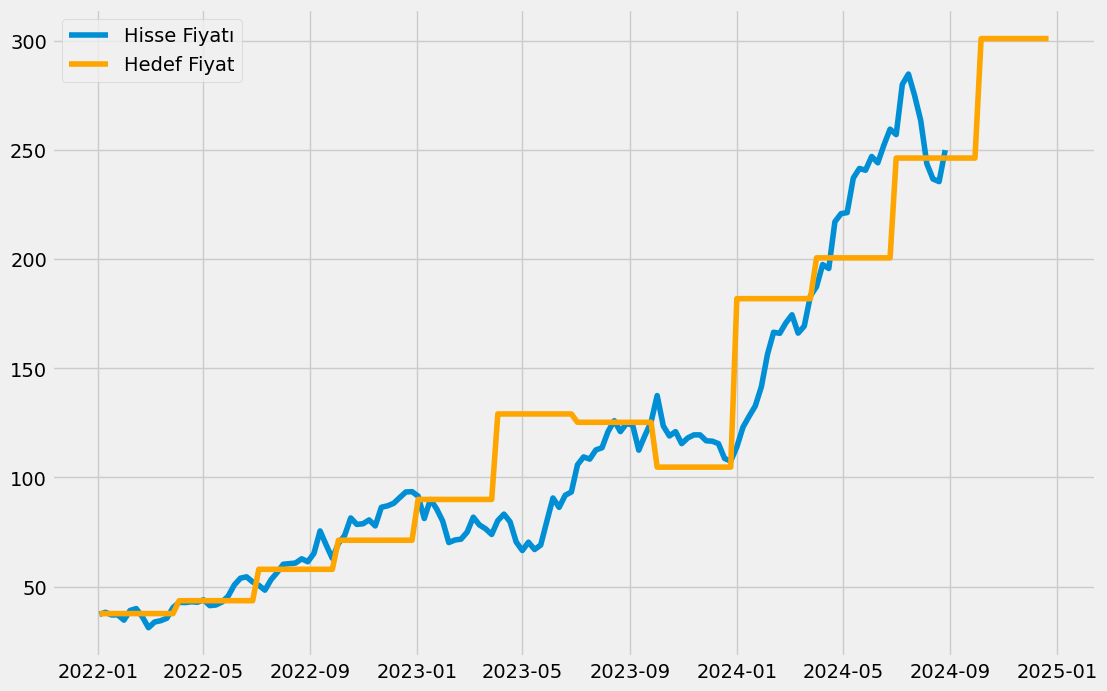

In [20]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12,8))
plt.plot(hisse["Close"],label="Hisse Fiyatı")
plt.plot(hisse["Hedef"],label="Hedef Fiyat",color="orange")
plt.plot(yeni["Hedef"].loc["2024-08-26":],color="orange")
plt.legend()